# Ensemble Machine Learning

Ensemble methods is a machine learning technique that combines several base models in order to produce one optimal predictive model. One of the ensemble method is Stacked Generalization or stacking, for short. It involves combining the predictions from multiple machine learning models on the same dataset, like bagging and boosting.

## Stacked Generalization (Stacking)

Stacking is an ensemble method that enables the model to learn how to use combine predictions given by learner models with meta-models and prepare a final model with accurate prediction. The main benefit of stacking ensemble is that it can shield the capabilities of a range of well-performing models to solve classification and regression problems. Further, it helps to prepare a better model having better predictions than all individual models. 

The main differences between bagging and boosting with stacking are
- Heterogenous base model learners. You can stack different models like, logistic regression, random forest, even neural network on base level
- Meta model or secondary level model

To give you more understanding about how stacking works, you can look at this diagram:

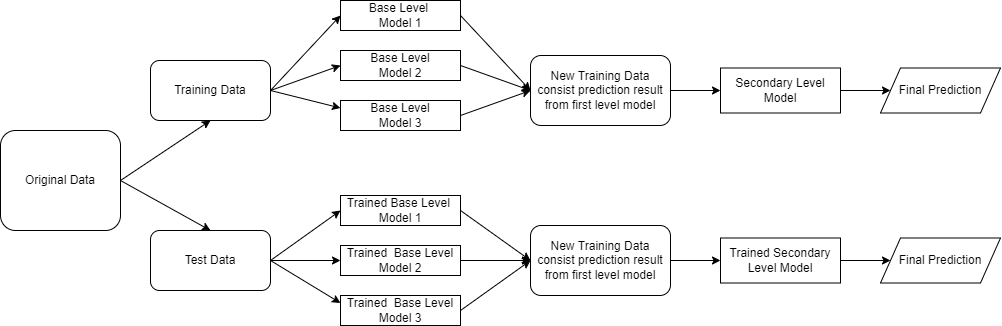

In [98]:
from IPython.display import Image

class Caption():
    def __init__(self,s):
        self.s = s
    def _repr_html_(self):
        return '<center>{0}</center>'.format(self.s)
    def _repr_latex_(self):
        return '\\begin{center}\n'+self.s+'\n\\end{center}'
    
display(Image(filename = 'assets/stacking_architecture.png'),Caption('Image by Author'))

## Binary Classification with Stacked Ensemble Method

In [87]:
import pandas as pd
import numpy as np
import copy as cp

from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, PredefinedSplit, GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

from collections.abc import Iterable
from more_itertools import powerset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE : int = 21
TARGET : int = 60
    
start = "\033[1m" #bold text formatting
end = "\033[0;0m" #bold text formatting

### Load Data

We use Sonar Dataset from [UCI ML Repository](http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)) for a binary classification problem. The Sonar Dataset involves the prediction of whether an object is a mine (M) or a rock (R) given the strength of sonar returns at different angles. The dataset contains the patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock.

In [64]:
data = pd.read_csv('data_input/sonar.all-data.csv', header = None)
data

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


#### Check class balance

<AxesSubplot:>

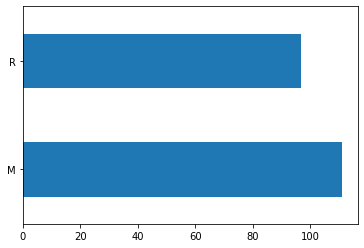

In [65]:
data[TARGET].value_counts().plot(kind='barh')

Change binary target to M as 0 and R as 1

In [66]:
data[TARGET] = np.where(data[TARGET] == 'M', 0, 1)

### Cross Validation

To better understand data splitting on stacking, you can take a look at this diagram:
1.  The first thing to do is divide the data into training sets and testing sets. In this case, the dataset is divided into 75% training set and 25% test set according to the default sklearn parameter.
2. The training set is then further divided into training data (K -1) and validation data (Kn) for the k-fold cross-validation approach. In this case, we use the stratified k-fold method so that each class has the same sample percentage.
3. Prediction results from the base models will be forwarded to the secondary level model as a feature or predictor variable. In this case, the features from the initial training set are also added as input for the secondary level model with the parameter `passthrough=True`.
4. The test set will go through the trained base level models and secondary level model and produce predictions on the test set.

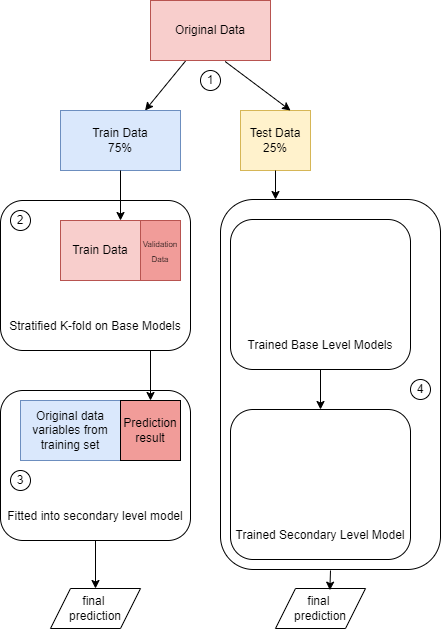

In [99]:
display(Image(filename = 'assets/dataset_process.png'),Caption('Image by Author'))

In [67]:
X = data.drop([TARGET], axis=1)
y = data[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=RANDOM_STATE, stratify = y)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
198,0.0238,0.0318,0.0422,0.0399,0.0788,0.0766,0.0881,0.1143,0.1594,0.2048,...,0.0186,0.0096,0.0071,0.0084,0.0038,0.0026,0.0028,0.0013,0.0035,0.0060
43,0.0093,0.0269,0.0217,0.0339,0.0305,0.1172,0.1450,0.0638,0.0740,0.1360,...,0.0309,0.0212,0.0091,0.0056,0.0086,0.0092,0.0070,0.0116,0.0060,0.0110
152,0.0131,0.0201,0.0045,0.0217,0.0230,0.0481,0.0742,0.0333,0.1369,0.2079,...,0.0111,0.0168,0.0086,0.0045,0.0062,0.0065,0.0030,0.0066,0.0029,0.0053
112,0.0454,0.0472,0.0697,0.1021,0.1397,0.1493,0.1487,0.0771,0.1171,0.1675,...,0.0137,0.0120,0.0042,0.0238,0.0129,0.0084,0.0218,0.0321,0.0154,0.0053
143,0.0516,0.0944,0.0622,0.0415,0.0995,0.2431,0.1777,0.2018,0.2611,0.1294,...,0.0456,0.0432,0.0274,0.0152,0.0120,0.0129,0.0020,0.0109,0.0074,0.0078


### Create Stacking Models

In [68]:
level_0_classifiers = dict()
level_0_classifiers["logreg"] = LogisticRegression(random_state=RANDOM_STATE)
level_0_classifiers["forest"] = RandomForestClassifier(random_state=RANDOM_STATE)
level_0_classifiers["xgboost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
level_0_classifiers["naive_bayes"] = GaussianNB()

level_1_classifier = ExtraTreesClassifier(random_state=RANDOM_STATE)

In [69]:
kfold = StratifiedKFold(n_splits=5, 
                        shuffle=True, 
                        random_state=RANDOM_STATE)
stacking_model = StackingClassifier(estimators=list(level_0_classifiers.items()), 
                                    final_estimator=level_1_classifier, 
                                    passthrough=True, 
                                    cv=kfold, 
                                    stack_method="predict_proba")

### Generate classification predictions on Base Models

In [70]:
level_0_columns = [f"{name}_prediction" for name in level_0_classifiers.keys()]
pd.DataFrame(stacking_model.fit_transform(X_train, y_train), 
             columns=level_0_columns + list(X_train.columns))

,logreg_prediction,forest_prediction,xgboost_prediction,naive_bayes_prediction,0,1,2,3,4,5,...,50,51,52,53,54,55,56,57,58,59
0,0.164869,0.05,0.002009,9.644011e-01,0.0238,0.0318,0.0422,0.0399,0.0788,0.0766,...,0.0186,0.0096,0.0071,0.0084,0.0038,0.0026,0.0028,0.0013,0.0035,0.0060
1,0.907384,0.86,0.989940,9.999998e-01,0.0093,0.0269,0.0217,0.0339,0.0305,0.1172,...,0.0309,0.0212,0.0091,0.0056,0.0086,0.0092,0.0070,0.0116,0.0060,0.0110
2,0.310623,0.14,0.018395,9.973717e-01,0.0131,0.0201,0.0045,0.0217,0.0230,0.0481,...,0.0111,0.0168,0.0086,0.0045,0.0062,0.0065,0.0030,0.0066,0.0029,0.0053
3,0.440388,0.12,0.014469,2.852317e-06,0.0454,0.0472,0.0697,0.1021,0.1397,0.1493,...,0.0137,0.0120,0.0042,0.0238,0.0129,0.0084,0.0218,0.0321,0.0154,0.0053
4,0.101352,0.07,0.002816,1.564162e-19,0.0516,0.0944,0.0622,0.0415,0.0995,0.2431,...,0.0456,0.0432,0.0274,0.0152,0.0120,0.0129,0.0020,0.0109,0.0074,0.0078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.609542,0.93,0.989820,9.998461e-01,0.0123,0.0309,0.0169,0.0313,0.0358,0.0102,...,0.0188,0.0133,0.0265,0.0224,0.0074,0.0118,0.0026,0.0092,0.0009,0.0044
152,0.395228,0.04,0.006778,9.981094e-01,0.0056,0.0267,0.0221,0.0561,0.0936,0.1146,...,0.0185,0.0072,0.0055,0.0074,0.0068,0.0084,0.0037,0.0024,0.0034,0.0007
153,0.776832,0.81,0.985969,4.371884e-01,0.0274,0.0242,0.0621,0.0560,0.1129,0.0973,...,0.0255,0.0113,0.0108,0.0085,0.0047,0.0074,0.0104,0.0161,0.0220,0.0173
154,0.679448,0.81,0.962554,2.370102e-09,0.0365,0.1632,0.1636,0.1421,0.1130,0.1306,...,0.0223,0.0110,0.0071,0.0205,0.0164,0.0063,0.0078,0.0094,0.0110,0.0068


### Generate Secondary Level Model Predictions 

In [71]:
pd.DataFrame(stacking_model.transform(X_val), columns=level_0_columns + list(X_train.columns))

,logreg_prediction,forest_prediction,xgboost_prediction,naive_bayes_prediction,0,1,2,3,4,5,...,50,51,52,53,54,55,56,57,58,59
0,0.856826,0.58,0.995391,9.141344e-01,0.0126,0.0519,0.0621,0.0518,0.1072,0.2587,...,0.0027,0.0208,0.0048,0.0199,0.0126,0.0022,0.0037,0.0034,0.0114,0.0077
1,0.832542,0.93,0.994148,1.000000e+00,0.0123,0.0022,0.0196,0.0206,0.0180,0.0492,...,0.0149,0.0125,0.0134,0.0026,0.0038,0.0018,0.0113,0.0058,0.0047,0.0071
2,0.585948,0.19,0.063328,9.720060e-01,0.0258,0.0433,0.0547,0.0681,0.0784,0.1250,...,0.0121,0.0091,0.0062,0.0019,0.0045,0.0079,0.0031,0.0063,0.0048,0.0050
3,0.874493,0.99,0.998764,1.000000e+00,0.0093,0.0185,0.0056,0.0064,0.0260,0.0458,...,0.0022,0.0069,0.0064,0.0129,0.0114,0.0054,0.0089,0.0050,0.0058,0.0025
4,0.049339,0.07,0.001364,1.810460e-11,0.0423,0.0321,0.0709,0.0108,0.1070,0.0973,...,0.0367,0.0176,0.0035,0.0093,0.0121,0.0075,0.0056,0.0021,0.0043,0.0017
5,0.093011,0.17,0.023201,8.412364e-37,0.0654,0.0649,0.0737,0.1132,0.2482,0.1257,...,0.0243,0.0210,0.0361,0.0239,0.0447,0.0394,0.0355,0.0440,0.0243,0.0098
6,0.407016,0.37,0.095162,2.226594e-13,0.0335,0.0134,0.0696,0.1180,0.0348,0.1180,...,0.0302,0.0244,0.0232,0.0093,0.0159,0.0193,0.0032,0.0377,0.0126,0.0156
7,0.554041,0.22,0.003628,9.996456e-01,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,...,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031
8,0.565260,0.52,0.396409,9.999649e-01,0.0134,0.0172,0.0178,0.0363,0.0444,0.0744,...,0.0046,0.0094,0.0048,0.0047,0.0016,0.0008,0.0042,0.0024,0.0027,0.0041
9,0.487306,0.56,0.331536,3.027603e-02,0.0206,0.0132,0.0533,0.0569,0.0647,0.1432,...,0.0307,0.0386,0.0147,0.0018,0.0100,0.0096,0.0077,0.0180,0.0109,0.0070


### Final Predictions

In [72]:
y_val_pred = stacking_model.predict(X_val)
y_val_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0])

### Evaluation

In [86]:
for name, classifier in level_0_classifiers.items():
    classifier_ = cp.deepcopy(classifier)
    classifier_.fit(X_train, y_train)

    print('Accuracy of ' + start + 'base level ' + end + f" {name} classifier: {accuracy_score(y_val, classifier_.predict(X_val))}")
    

print('Accuracy of ' + start + 'secondary level ' + end + f"stacking classifier: {accuracy_score(y_val, y_val_pred)}")

Accuracy of base level  logreg classifier: 0.7115384615384616
Accuracy of base level  forest classifier: 0.8076923076923077
Accuracy of base level  xgboost classifier: 0.8076923076923077
Accuracy of base level  naive_bayes classifier: 0.6923076923076923
Accuracy of secondary level stacking classifier: 0.8461538461538461


### References:
- [sklearn Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)
- [sklearn Stratified Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
- [Harrison Graham, A Deep Dive into Stacking Ensemble Machine Learning](https://towardsdatascience.com/a-deep-dive-into-stacking-ensemble-machine-learning-part-ii-69bfc0d6e53d)
- [Javatpoint, Stacking in Machine Learning](https://www.javatpoint.com/stacking-in-machine-learning)